# Install the easy-vqa package

In [ ]:
# this package has all the data needed to train our model
!pip install easy-vqa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 3.6 MB/s eta 0:00:00


# Data Preprocessing - Text

In [ ]:
from easy_vqa import get_train_questions, get_test_questions, get_train_image_paths, get_test_image_paths, get_answers

In [ ]:
print('\n--- Reading questions...')
# Use the easy-vqa package
train_qs, train_answers, train_image_ids = get_train_questions()
test_qs, test_answers, test_image_ids = get_test_questions()
print(f'Read {len(train_qs)} training questions and {len(test_qs)} testing questions.')


--- Reading questions...
Read 38575 training questions and 9673 testing questions.


In [ ]:
test_qs[10:20]

['is there a brown shape?',
 'what is the color of the rectangle?',
 'is there not a circle in the image?',
 'is there a triangle?',
 'does the image contain a triangle?',
 'does the image contain a black shape?',
 'is no green shape present?',
 'is there a brown shape in the image?',
 'what is the blue shape?',
 'what is the color of the triangle?']

In [ ]:
print('\n--- Reading answers...')
all_answers = get_answers()
num_answers = len(all_answers)
print(f'Found {num_answers} total answers:')
print(all_answers)


--- Reading answers...
Found 13 total answers:
['circle', 'green', 'red', 'gray', 'yes', 'teal', 'black', 'rectangle', 'yellow', 'triangle', 'brown', 'blue', 'no']


# Data Preprocessing - Images

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.transforms import functional as F
from PIL import Image

def load_and_process_image(image_path):
    # Load image
    im = Image.open(image_path)
    im = F.to_tensor(im)
    return im

def read_images(paths):
    # paths is a dict mapping image ID to image path
    # Returns a dict mapping image ID to the processed image
    ims = {}
    for image_id, image_path in paths.items():
        ims[image_id] = load_and_process_image(image_path)
    return ims

print('--- Reading/processing images from image paths of the vqa library ---\n')
train_ims = read_images(get_train_image_paths())
test_ims = read_images(get_test_image_paths())
im_shape = train_ims[0].shape
print(f'Read {len(train_ims)} training images and {len(test_ims)} testing images.')
print(f'Each image has shape {im_shape}.')

--- Reading/processing images from image paths of the vqa library ---

Read 4000 training images and 1000 testing images.
Each image has shape torch.Size([3, 64, 64]).


# A peek into the image+text data

In [ ]:
import pandas as pd
df = pd.DataFrame(list(zip(train_qs, train_answers, train_image_ids)), columns =['Question', 'Answer', 'Image ID'])
df.head(10)

,Question,Answer,Image ID
0,what is the blue shape?,rectangle,0
1,what color is the shape?,blue,0
2,does the image contain a rectangle?,yes,0
3,is there a triangle in the image?,no,0
4,is there a black shape?,no,0
5,does the image not contain a gray shape?,yes,0
6,is there a red shape in the image?,no,0
7,does the image not contain a red shape?,yes,0
8,is there not a blue shape?,no,0
9,is there not a blue shape in the image?,no,0


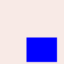

In [ ]:
import torchvision.utils as utils
from torchvision import transforms

# print multiple images
# images = 1
# batch = torch.empty((images, 3, 64, 64))
# for i in range(images):
#     batch[i] = train_ims[i]

# Create a grid of images
id = 0
grid = utils.make_grid(train_ims[id], nrow=2)
# Convert the grid to a PIL image
image = transforms.ToPILImage()(grid)
# Show the image
image.show()

# Creating a Bag of Words vectors for questions

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# create the vectorizer, fit to train and transform both train and test
vectorizer = CountVectorizer(binary=True)
train_vectorizer = vectorizer.fit(train_qs)
train_X_seqs = train_vectorizer.transform(train_qs)
test_X_seqs = train_vectorizer.transform(test_qs)

In [ ]:
# You can see the dictionary created 
vocab_size = len(vectorizer.vocabulary_)
vectorizer.vocabulary_

{'what': 23,
 'is': 11,
 'the': 20,
 'blue': 1,
 'shape': 18,
 'color': 4,
 'does': 6,
 'image': 9,
 'contain': 5,
 'rectangle': 16,
 'there': 21,
 'triangle': 22,
 'in': 10,
 'black': 0,
 'not': 13,
 'gray': 7,
 'red': 17,
 'yellow': 24,
 'teal': 19,
 'present': 15,
 'green': 8,
 'of': 14,
 'circle': 3,
 'no': 12,
 'brown': 2}

In [ ]:
# converting scipy array to numpy array
train_X_seqs = train_X_seqs.toarray()
test_X_seqs = test_X_seqs.toarray()

# Questions in array format
print(f'\nbinary vectors in array(dense) format') 
print(train_X_seqs)
print(f'\nThe shape of the binary vectors is : {train_X_seqs.shape}')


binary vectors in array(dense) format
[[0 1 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

The shape of the binary vectors is : (38575, 25)


In [ ]:
# lets visualize it better 
features = vectorizer.get_feature_names_out()
df_count = pd.DataFrame(train_X_seqs, columns = features)
df_count

,black,blue,brown,circle,color,contain,does,gray,green,image,...,present,rectangle,red,shape,teal,the,there,triangle,what,yellow
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2,0,0,0,0,0,1,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38570,0,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
38571,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
38572,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
38573,0,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0


In [ ]:
# finally convert the question vectors to tensor and fix the data type so it wouldnt error in the fully connected layer
train_X_seqs = torch.tensor(train_X_seqs, dtype=torch.long) # convert ndarray to tensor
train_X_seqs = train_X_seqs.float()                         # convert dtype to float32 to match weights (so that mat1 and mat2 can multiply)
test_X_seqs = torch.tensor(test_X_seqs, dtype=torch.long)
test_X_seqs = test_X_seqs.float()

# Creating images corresponding to each question based on id

In [ ]:
import numpy as np

print('\n--- Creating model input images...')
train_X_ims = np.array([train_ims[id] for id in train_image_ids])
test_X_ims = np.array([test_ims[id] for id in test_image_ids])


--- Creating model input images...


<ipython-input-13-1909653ea45c>:4: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  train_X_ims = np.array([train_ims[id] for id in train_image_ids])
<ipython-input-13-1909653ea45c>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_X_ims = np.array([train_ims[id] for id in train_image_ids])
<ipython-input-13-1909653ea45c>:5: FutureWarning: The input object of type

In [ ]:
type(train_X_ims)

numpy.ndarray

# Encoding answers as binary vectors


In [ ]:
print('\n--- Creating model outputs...')

train_answer_indices = np.array([all_answers.index(a) for a in train_answers])
test_answer_indices = np.array([all_answers.index(a) for a in test_answers])

#creating a 2D array filled with 0's
train_Y = np.zeros((train_answer_indices.size, train_answer_indices.max()+1), dtype=int)
test_Y = np.zeros((test_answer_indices.size, test_answer_indices.max()+1), dtype=int)

#replacing 0 with a 1 at the index of the original array
train_Y[np.arange(train_answer_indices.size),train_answer_indices] = 1
test_Y[np.arange(test_answer_indices.size),test_answer_indices] = 1 

# finally convert the label vectors to tensor and fix the data type so it wouldnt error in the fully connected layer
train_Y = torch.tensor(train_Y, dtype=torch.long)
train_Y = train_Y.float()
test_Y = torch.tensor(test_Y, dtype=torch.long)
test_Y = test_Y.float()

print(f'Example model output: {train_Y[0]}')
print(f'data type {type(train_Y)}')


--- Creating model outputs...
Example model output: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
data type <class 'torch.Tensor'>


# Inputs to model

Now we have the following varibles as input to our model
-  [`train_X_ims`, `train_X_seqs`, `train_Y`]  - train image-question-answer input
-  [`test_X_ims`, `test_X_seqs`, `test_Y`] - test image-question-answer input
-  vocab_size - size of vocab for input node count
-  im_shape - shape of image for input node count
-  num_answers - number of answers for output layer node count

# Save data to pickle files

In [ ]:
# set path
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/FSDL/'
project_path = Path(project_path)

Mounted at /content/drive


In [ ]:
# # save data
# import pickle
# with open(project_path/'train_img.pickle', 'wb') as handle:
#     pickle.dump(train_X_ims, handle)
# with open(project_path/'train_qsn.pickle', 'wb') as handle:
#     pickle.dump(train_X_seqs, handle)
# with open(project_path/'train_ans.pickle', 'wb') as handle:
#     pickle.dump(train_Y, handle)
# with open(project_path/'test_img.pickle', 'wb') as handle:
#     pickle.dump(test_X_ims, handle)
# with open(project_path/'test_qsn.pickle', 'wb') as handle:
#     pickle.dump(test_X_seqs, handle)
# with open(project_path/'test_ans.pickle', 'wb') as handle:
#     pickle.dump(test_Y, handle)

# # load data
# with open(project_path/'train_img.pickle', 'rb') as handle:
#     train_X_ims = pickle.load(handle)
# with open(project_path/'train_qsn.pickle', 'rb') as handle:
#     train_X_seqs = pickle.load(handle)
# with open(project_path/'train_ans.pickle', 'rb') as handle:
#     train_Y = pickle.load(handle)
# with open(project_path/'test_img.pickle', 'rb') as handle:
#     test_X_ims = pickle.load(handle)
# with open(project_path/'test_qsn.pickle', 'rb') as handle:
#     test_X_seqs = pickle.load(handle)
# with open(project_path/'test_ans.pickle', 'rb') as handle:
#     test_Y = pickle.load(handle)

# Set seed for reproducibility

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed

<function __main__.set_seed(seed: int = 42) -> None>

# Custom Dataset

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, img, txt, ans):
      self.img = img
      self.txt = txt
      self.ans = ans

    def __len__(self):
        return len(self.ans)

    def __getitem__(self, idx):
      ans = self.ans[idx]
      img = self.img[idx]
      txt = self.txt[idx]
      return img, txt, ans

# Train and Evaluate loops

In [ ]:
def train_loop(model, optimizer, criterion, train_loader):
    model.train()
    model.to(device)
    total_loss, total = 0, 0

    for image, text, label in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        image, text, label =  image.to(device), text.to(device), label.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model.forward(image, text)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        # Record metrics
        total_loss += loss.item()
        total += len(label)

    return total_loss / total


def validate_loop(model, criterion, valid_loader):
    model.eval()
    model.to(device)
    total_loss, total = 0, 0

    with torch.no_grad():
      for image, text, label in testloader:
          # get the inputs; data is a list of [inputs, labels]
          image, text, label =  image.to(device), text.to(device), label.to(device)

          # Forward pass
          output = model.forward(image, text)

          # Calculate how wrong the model is
          loss = criterion(output, label)

          # Record metrics
          total_loss += loss.item()
          total += len(label)

    return total_loss / total

# Model

In [ ]:
import torch
import torch.nn as nn
from torch import mul, cat, tanh, relu

class VQA(nn.Module):
  def __init__(self, vocab_size, num_answers):
    super(VQA, self).__init__()

    # The CNN
    self.conv1 = nn.Conv2d(3, 8, kernel_size=3)   # output shape (batch_size, 8, 62, 62)
    self.pool1 = nn.MaxPool2d(kernel_size=2)      # output shape (batch_size, 8, 31, 31)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3)  # output shape (batch_size, 16, 29, 29)
    self.pool2 = nn.MaxPool2d(kernel_size=2)      # output shape (batch_size, 16, 14, 14)
    self.conv3 = nn.Conv2d(16, 32, kernel_size=3) # output shape (batch_size, 32, 12, 12)
    self.pool3 = nn.MaxPool2d(kernel_size=2)      # output shape (batch_size, 32, 6, 6)
    self.fc1 = nn.Linear(32*6*6, 32)              # (batch_size, 1152) and (1152, 32) --> (input and weight matrices) --> (batch_size, 32)

    # The question network  (32x32 and 64x32)
    self.fc2 = nn.Linear(vocab_size, 32)          # (32, 32)
    self.fc3 = nn.Linear(32, 32)                  # (32, 32)

    # Merge -> output
    self.fc4 = nn.Linear(64, 32)                  
    self.fc5 = nn.Linear(32, num_answers)

  def forward(self, x, q):
    # The CNN
    x = self.pool1(relu(self.conv1(x)))
    x = self.pool2(relu(self.conv2(x)))
    x = self.pool3(relu(self.conv3(x)))
    x = x.view(-1, 32*6*6)
    x = tanh(self.fc1(x))                         # (batch_size, 32)

    # The question network
    q = tanh(self.fc2(q))                         # (32, 32)
    q = tanh(self.fc3(q))                         # (32, 32)

    # Merge -> output                              
    out = cat((x, q), 1)
    out = tanh(self.fc4(out))
    out = self.fc5(out)
    return out

# Hyperparameters, Logging and DataLoaders

In [ ]:
!pip install WandB
import wandb
!wandb login --relogin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=0b9da7c06ad21504e82daacb8f100d95972fc71bbeafda743b8f92d999d35b64
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or pr

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

In [ ]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
# WandB – Initialize a new run
wandb.init(project='easy-vqa-pytorch', name='CNN-BoW-tanh-40Epoch', notes='Fourth run')

# WandB – Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config          # Initialize config
config.batch_size = 32          # input batch size for training (default: 64)
config.test_batch_size = 32    # input batch size for testing (default: 1000)
config.epochs = 40            # number of epochs to train (default: 10)
config.lr = 0.005               # learning rate (default: 0.01)
config.momentum = 0.1          # SGD momentum (default: 0.5) 
config.no_cuda = False         # disables CUDA training
config.log_interval = 10     # how many batches to wait before logging training status


if torch.cuda.is_available(): device = torch.device("cuda:0")
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}


# Now we load our training and test datasets initialize the train, validation, and test data loaders

train_dataset = CustomDataset(train_X_ims, train_X_seqs, train_Y)
test_dataset = CustomDataset(test_X_ims, test_X_seqs, test_Y)
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=config.batch_size)
testloader = DataLoader(test_dataset, batch_size=config.test_batch_size)


# Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
model = VQA(vocab_size = vocab_size, num_answers = num_answers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.lr,
                      momentum=config.momentum)

# WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
# Using log="all" log histograms of parameter values in addition to gradients
wandb.watch(model, log="all")
early_stopper = EarlyStopper(patience=2, min_delta=0.03)
train_losses, valid_losses = [], []

for epoch in range(config.epochs):
    train_loss = train_loop(model, optimizer, criterion, trainloader)
    valid_loss = validate_loop(model, criterion, testloader)
    
    tqdm.write(
        f'epoch #{epoch + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    wandb.log({
      "Epoch": epoch,
      "Training Loss": train_loss,
      "Validation Loss": valid_loss})

    if early_stopper.early_stop(valid_loss):             
      break

wandb: Currently logged in as: nimblefox. Use `wandb login --relogin` to force relogin


epoch #  1	train_loss: 5.38e-02	valid_loss: 4.72e-02

epoch #  2	train_loss: 3.87e-02	valid_loss: 3.46e-02

epoch #  3	train_loss: 3.25e-02	valid_loss: 3.03e-02

epoch #  4	train_loss: 2.97e-02	valid_loss: 2.89e-02

epoch #  5	train_loss: 2.85e-02	valid_loss: 2.77e-02

epoch #  6	train_loss: 2.72e-02	valid_loss: 2.63e-02

epoch #  7	train_loss: 2.61e-02	valid_loss: 2.53e-02

epoch #  8	train_loss: 2.52e-02	valid_loss: 2.47e-02

epoch #  9	train_loss: 2.47e-02	valid_loss: 2.43e-02

epoch # 10	train_loss: 2.45e-02	valid_loss: 2.42e-02

epoch # 11	train_loss: 2.43e-02	valid_loss: 2.39e-02

epoch # 12	train_loss: 2.42e-02	valid_loss: 2.38e-02

epoch # 13	train_loss: 2.41e-02	valid_loss: 2.38e-02

epoch # 14	train_loss: 2.40e-02	valid_loss: 2.37e-02

epoch # 15	train_loss: 2.39e-02	valid_loss: 2.37e-02

epoch # 16	train_loss: 2.39e-02	valid_loss: 2.36e-02

epoch # 17	train_loss: 2.38e-02	valid_loss: 2.36e-02

epoch # 18	train_loss: 2.38e-02	valid_loss: 2.36e-02

epoch # 19	train_loss: 2.37e

# Training

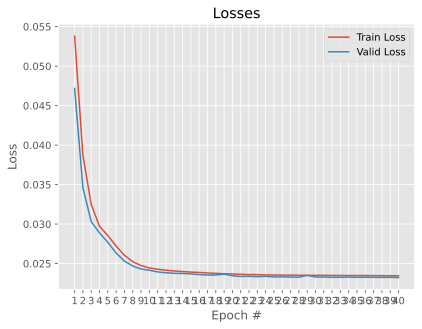

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')


epoch_ticks = range(1, epoch + 2)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

# Accuracy

In [ ]:
model.eval()
model.to(device)
num_correct = 0
num_samples = 0
predictions = []
answers = []

with torch.no_grad():
    for image, text, label in testloader:
        image, text, label =  image.to(device), text.to(device), label.to(device)
        probs = model.forward(image, text)

        _, prediction = probs.max(1)
        predictions.append(prediction)      

        answer = torch.argmax(label, dim=1) 
        answers.append(answer)

        num_correct += (prediction == answer).sum()
        num_samples += prediction.size(0)
        
    valid_acc = (f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')     
    print(valid_acc)

    wandb.log({
    "Validation Accuracy": round(float(num_correct)/float(num_samples)*100, 2)})        

Got 6552 / 9673 with accuracy 67.73


In [ ]:
# predictions = torch.cat(predictions, dim=0)
# answers = torch.cat(answers, dim=0)

In [ ]:
# #!pip install torcheval # f1 score
# from torcheval.metrics.functional import multiclass_f1_score
# predictions = torch.cat(predictions, dim=0)
# answers = torch.cat(answers, dim=0)
# multiclass_f1_score(predictions, answers, num_classes=13)
break

# Save and load model

In [ ]:
# set path
# from pathlib import Path
# from google.colab import drive
# drive.mount('/content/drive')
# project_path = '/content/drive/MyDrive/FSDL/'
# project_path = Path(project_path)

# torch.save(model.state_dict(), project_path/'newset')
model = VQA(vocab_size = 25, num_answers = 13)
model.load_state_dict(torch.load(project_path/'newset'))
model.eval()

VQA(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=32, bias=True)
  (fc2): Linear(in_features=25, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=13, bias=True)
)

In [ ]:
from torch.utils.data import DataLoader
train_dataset = CustomDataset(train_X_ims, train_X_seqs, train_Y)
test_dataset = CustomDataset(test_X_ims, test_X_seqs, test_Y)
trainloader = DataLoader(train_dataset, shuffle=True, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)

In [ ]:
#model.to(device)
with torch.no_grad():
    for image, text, label in testloader:
        image, text, label =  image, text, label
        probs = model.forward(image, text)
        print(probs)
        break

tensor([[ 4.7088, -1.0701, -1.1138, -1.1717, -4.6257, -1.0193, -1.1021,  4.7497,
         -1.1118,  4.7757, -0.9891, -0.8938, -1.4652]])


In [ ]:
with torch.no_grad():
    for image, text, label in testloader:
        image, text, label =  image, text, label
        probs = model.forward(image, text)
        answer_idx = torch.argmax(probs, dim=1) # get index of answer with highest probability
        answer_text = [all_answers[idx] for idx in answer_idx] # convert index to answer text
        print(answer_text)
        break

# Misc : Debugging and analysis

In [ ]:
conv1 = nn.Conv2d(3, 8, kernel_size=3)
pool1 = nn.MaxPool2d(kernel_size=2)
conv2 = nn.Conv2d(8, 16, kernel_size=3)
pool2 = nn.MaxPool2d(kernel_size=2)
conv3 = nn.Conv2d(16, 32, kernel_size=3) # output shape (batch_size, 32, 12, 12)
pool3 = nn.MaxPool2d(kernel_size=2)      # output shape (batch_size, 32, 6, 6)

fc1 = nn.Linear(32*6*6, 32)
fc2 = nn.Linear(vocab_size, 32)        
fc3 = nn.Linear(32, 32)
fc4 = nn.Linear(32, 32)
fc5 = nn.Linear(32, num_answers)

In [ ]:
a = train_X_ims[0]
print(a.shape)
a = conv1(a)
print(a.shape)
a = pool1(a)
print(a.shape)
a = conv2(a)
print(a.shape)
a = pool2(a)
print(a.shape)
a = conv3(a)
print(a.shape)
a = pool3(a)
print(a.shape)
a = a.view(-1)
print(a.shape)
a = fc1(a)     # (1x3136 and 3136x32) --> (input and weights) --> (1x32)
print(a.shape)
print(fc1.weight.dtype, a.dtype)

In [ ]:
b = train_X_seqs[0]
print(b.shape)
b = torch.tensor(b, dtype=torch.float) # convert ndarray to tensor                        
print(fc2.weight.dtype, b.dtype)
b = fc2(b)
print(b.shape)
b = fc3(b)
print(b.shape)

In [ ]:
out = torch.cat((a, b), 0)
out.shape

In [ ]:
out = torch.mul(a, b)
out.shape

In [ ]:
#out = mul(x, q)
out = torch.tanh(fc4(out))
print(out.shape)
out = fc5(out)
print(out.shape)

In [ ]:
out

In [ ]:
d = model(train_X_ims[0], train_X_seqs[0])
d

In [ ]:
d.dtype

In [ ]:
label.dtype

In [ ]:
outputs.dtype